In [48]:
from contextlib import closing
import os
import platform
import socket
import subprocess
from subprocess import PIPE
import tempfile
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from py4j.java_gateway import JavaGateway, GatewayParameters
from py4j.java_collections import ListConverter

In [49]:
#%python -m pip install scipy
%pip install scipy
import scipy


You should consider upgrading via the '/Users/andrea/Documents/python_envs/env_research/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [41]:
__ERODE_JAR__ = "erodeMetrics.jar"#os.path.join(os.path.dirname(__file__), "erodeMetrics.jar")
def _start_server():
    # find a free port
    for port in range(25333, 65545):
        with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
            dest_addr = ("127.0.0.1", port)
            if s.connect_ex(dest_addr):
                break

    #ld_path = __ERODE_LIB_DIR__
    #java="java"
    java ="/Library/Java/JavaVirtualMachines/jdk-11.0.14.jdk/Contents/Home/bin/java"
    argv = [java, #f'-Djava.library.path="{ld_path}"',
                "-jar", __ERODE_JAR__, str(port)]

    if platform.system() == "Linux":
        env_ld_path = os.getenv("LD_LIBRARY_PATH")
        if env_ld_path:
            ld_path = f"{ld_path}:{env_ld_path}"
        env ={"LD_LIBRARY_PATH": ld_path}
        proc = subprocess.Popen(" ".join(argv), stdout=PIPE,
                shell=True, env=env)
    else:
        proc = subprocess.Popen(argv, stdout=PIPE)
    proc.stdout.readline()
    time.sleep(2) # Sleep for 1 second
    return proc, port

def _stop_server(proc):
    print('Terminating JVM and ERODE')
    time.sleep(1) # Sleep for 1 second
    proc.terminate()
    try:
        proc.wait(5)
    except subprocess.TimeoutExpired:
        proc.kill()
        proc.wait()
    print(' Completed')

def start_JVM():
    print('Starting the JVM and ERODE')
    _proc, _port = _start_server()
    gw_params = GatewayParameters(port=_port)#, auto_convert=True)
    _gw = JavaGateway(gateway_parameters=gw_params)
    erode = _gw.entry_point
    #print(_proc)
    #_port
    print('  Completed')
    return erode,_proc,_port
        
def j_to_py_matrix(metrics_java):
    metrics_python= [ list(line) for line in metrics_java ]
    return metrics_python        

In [42]:
def loadERODESparseMatrix(AmatrixFile):
    Asparse=pd.read_csv(AmatrixFile)
    Asparse.columns=["row","column","A_{r,c}"]
    Asparse0=Asparse-1
    Asparse0["A_{r,c}"]=Asparse["A_{r,c}"]
    return Asparse0
#Asparse=loadERODESparseMatrix("test2.csv")
#Asparse

def loadERODEB(BFile):
    #pd.read_csv("test2B.csv")
    B=pd.read_csv(BFile,header=None)
    return B
#B=loadERODEB("test2B.csv")
#B

def visualizeSystem(Afile,Bfile):
    Asparse=loadERODESparseMatrix(Afile)
    B=loadERODEB(Bfile)
    
    print('Computing metrics on following Ax=B system')
    print('A (in sparse format)')
    print(Asparse.to_string(index=False))
    print('\nB')
    print(B.to_string(header=False))
    print()

#_port=100    
    
def _computeMetrics(filename1,filename2,erode,_proc,_port,my_lambda,printModel,printPartitions):
    print('Loading the model in ERODE')
    if filename1.endswith('.csv'):
        erode.importAffine(filename1,filename2)
    else :
        erode.importPRISMDTMC(filename1,filename2)
    
    nVars=erode.getVariablesNum()

    if printModel:
        modelString=erode.getModelString()
        print(modelString)

    print('Computing the BB partition')
    obtained = erode.computeBB();
    if printPartitions:
        print(erode.getPartitionString(obtained))
    else:
        nBlocks=len(set(obtained))
        print('We obtained',nBlocks,'blocks out of',len(obtained),"variables")

    print('Computing the metrics')
    interestingValue=False
    metrics = erode.computeMetrics(obtained, my_lambda);
    for r in range(nVars):
        for c in range(nVars):
            print(metrics[r][c],end=" ")
            if metrics[r][c] > 0 and metrics[r][c] < 1:
                interestingValue=True
        print()
    if interestingValue:
        print('INTERESTING VALUE in (0,1)!!!!!!!!')
        print()
        
    #_stop_server(_proc)
    return metrics
    
def computeMetrics(filename1,filename2,erode,_proc,_port,my_lambda,printModel,printPartitions,annotateHeatMap):
    if filename1.endswith(".csv") and printModel:
        visualizeSystem(filename1,filename2)
    metrics=_computeMetrics(filename1,filename2,erode,_proc,_port,my_lambda,printModel,printPartitions)
    py_metrics=j_to_py_matrix(metrics)
    py_metrics_set = set()
    for row in py_metrics:
        py_metrics_set.update(row)
    py_metrics_list_single = list(py_metrics_set)
    py_metrics_list_single.sort()
    print('The values of the metrics, sorted')
    print(py_metrics_list_single)
    plt.plot(py_metrics_list_single)
    plt.show()
    #_stop_server(_proc)
    sns.heatmap(py_metrics,annot=annotateHeatMap,linewidths=.5,cbar=False)
    plt.savefig(filename1.replace(".csv","")+"_lambda"+str(my_lambda)+".pdf")
    sns.clustermap(py_metrics)
    return py_metrics
#_stop_server(_proc)

In [43]:
def computeMetrics_handleJVM(filename,fileName2,my_lambda,printModel,printPartitions,annotateHeatMap):
    erode,_proc,_port = start_JVM()
    py_metrics = computeMetrics(filename,fileName2,erode,_proc,_port,my_lambda,printModel,printPartitions,annotateHeatMap);
    _stop_server(_proc)

## Test Matrices

In [44]:
%time printModel=False

CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 67 µs


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 4 blocks out of 4 variables
Computing the metrics
0.0 3.0 6.0 4.0 
3.0 0.0 3.0 1.0 
6.0 3.0 0.0 2.0 
4.0 1.0 2.0 0.0 
The values of the metrics, sorted
[0.0, 1.0, 2.0, 3.0, 4.0, 6.0]


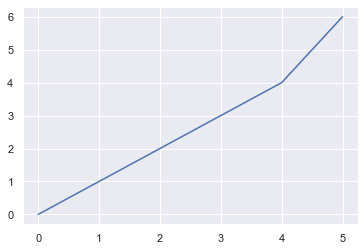

RuntimeError: clustermap requires scipy to be available

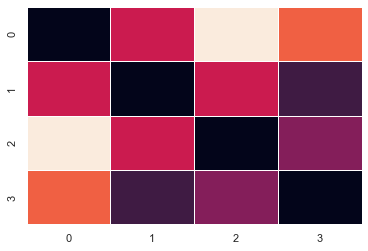

In [45]:
%time printModel=False
printPartitions=False
annotateHeatMap=False
computeMetrics_handleJVM('test.csv','testB.csv',1.0,printModel,printPartitions,annotateHeatMap)

## DTMCs

Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 2 blocks out of 8 variables
Computing the metrics
0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
0.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 
The values of the metrics, sorted
[0.0, 1.0]


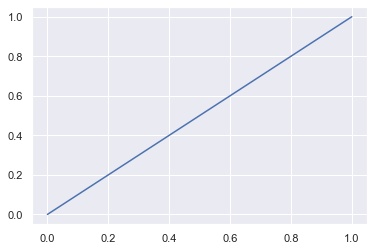

Terminating JVM and ERODE
 Completed
CPU times: user 338 ms, sys: 546 ms, total: 884 ms
Wall time: 6.47 s


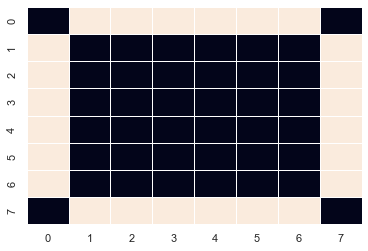

In [23]:
printModel=False
printPartitions=False
annotateHeatMap=False
%time computeMetrics_handleJVM('prismdtmc/hermann3.tra','prismdtmc/hermann3.lab',1.0,printModel,printPartitions,annotateHeatMap)

Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 4 blocks out of 32 variables
Computing the metrics
0.0 0.5 0.5 0.75 0.5 1.75 0.75 0.75 0.5 1.75 1.75 1.75 0.75 1.75 0.75 0.5 0.5 0.75 1.75 0.75 1.75 1.75 1.75 0.5 0.75 0.75 1.75 0.5 0.75 0.5 0.5 0.0 
0.5 0.0 0.0 0.25 0.0 1.25 0.25 0.25 0.0 1.25 1.25 1.25 0.25 1.25 0.25 0.0 0.0 0.25 1.25 0.25 1.25 1.25 1.25 0.0 0.25 0.25 1.25 0.0 0.25 0.0 0.0 0.5 
0.5 0.0 0.0 0.25 0.0 1.25 0.25 0.25 0.0 1.25 1.25 1.25 0.25 1.25 0.25 0.0 0.0 0.25 1.25 0.25 1.25 1.25 1.25 0.0 0.25 0.25 1.25 0.0 0.25 0.0 0.0 0.5 
0.75 0.25 0.25 0.0 0.25 1.0625 0.0 0.0 0.25 1.0625 1.0625 1.0625 0.0 1.0625 0.0 0.25 0.25 0.0 1.0625 0.0 1.0625 1.0625 1.0625 0.25 0.0 0.0 1.0625 0.25 0.0 0.25 0.25 0.75 
0.5 0.0 0.0 0.25 0.0 1.25 0.25 0.25 0.0 1.25 1.25 1.25 0.25 1.25 0.25 0.0 0.0 0.25 1.25 0.25 1.25 1.25 1.25 0.0 0.25 0.25 1.25 0.0 0.25 0.0 0.0 0.5 
1.75 1.25 1.25 1.0625 1.25 0.0 1.0625 1.0625 1.25 0.0 0.0 0.0 1.0625 0.0 1.06

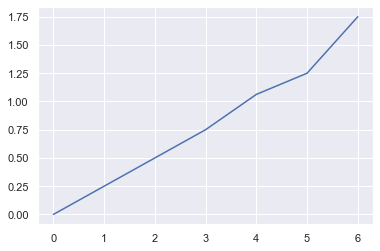

Terminating JVM and ERODE
 Completed
CPU times: user 663 ms, sys: 717 ms, total: 1.38 s
Wall time: 1min 7s


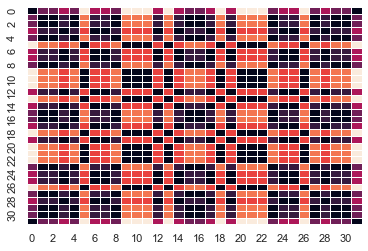

In [34]:
#"ciao".endswith('o')
#computeMetrics_handleJVM('prismdtmc/hermann3_simple.tra','prismdtmc/hermann3_simple.lab')
#computeMetrics_handleJVM('prismdtmc/hermann3.tra','prismdtmc/hermann3.lab')
#computeMetrics_handleJVM('test2.csv','test2B.csv')

%time computeMetrics_handleJVM('prismdtmc/hermann5.tra','prismdtmc/hermann5.lab',1.0,printModel,printPartitions,annotateHeatMap)
#computeMetrics_handleJVM('test.csv','testB.csv')

Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 5 blocks out of 26 variables
Computing the metrics
0.0 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 2.125 5.0 
2.125 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 7.125 
2.125 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 7.125 
2.125 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 7.125 
2.125 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 7.125 
2.125 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125 1.125

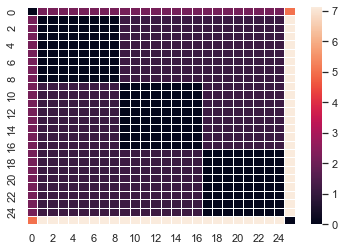

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


In [9]:
%time computeMetrics_handleJVM('prismdtmc/leader_sync3_2.tra','prismdtmc/leader_sync3_2.lab',1.0,printModel,printPartitions,annotateHeatMap)



Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 11 blocks out of 11 variables
Computing the metrics
0.0 1.1375 1.275 1.55 2.1 3.66875 1.9 1.45 1.225 1.1125 2.0125 
1.1375 0.0 0.275 0.55 1.1 3.5 0.9 0.45 0.225 0.025 1.1375 
1.275 0.275 0.0 0.55 1.1 3.5 0.9 0.45 0.05 0.275 1.275 
1.55 0.55 0.55 0.0 1.1 3.5 0.9 0.1 0.55 0.55 1.55 
2.1 1.1 1.1 1.1 0.0 4.6 0.2 1.1 1.1 1.1 2.1 
3.66875 3.5 3.5 3.5 4.6 0.0 4.4 3.5 3.5 3.5 3.68125 
1.9 0.9 0.9 0.9 0.2 4.4 0.0 0.9 0.9 0.9 1.9 
1.45 0.45 0.45 0.1 1.1 3.5 0.9 0.0 0.45 0.45 1.45 
1.225 0.225 0.05 0.55 1.1 3.5 0.9 0.45 0.0 0.225 1.225 
1.1125 0.025 0.275 0.55 1.1 3.5 0.9 0.45 0.225 0.0 1.1125 
2.0125 1.1375 1.275 1.55 2.1 3.68125 1.9 1.45 1.225 1.1125 0.0 
INTERESTING VALUE in (0,1)!!!!!!!!

Terminating JVM and ERODE


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


 Completed
CPU times: user 291 ms, sys: 550 ms, total: 841 ms
Wall time: 6.68 s


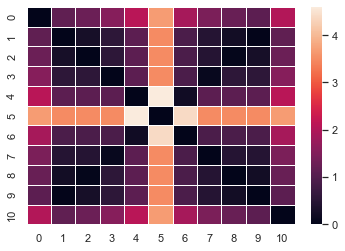

In [10]:
%time computeMetrics_handleJVM('prismdtmc/haddad-monmege.v1n5p0.6.tra','prismdtmc/haddad-monmege.v1nn5p0.6.lab',1.0,printModel,printPartitions,False)


Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 39 blocks out of 57 variables
Computing the metrics
0.0 5.00463 4.01389 4.01389 0.00463 3.01389 3.02778 0.01389 3.01389 0.01389 0.00463 2.01389 2.02778 0.01389 2.02778 0.02778 0.01389 2.01389 0.01389 0.01389 0.00463 1.01389 1.02778 0.01389 1.02778 0.02778 0.01389 1.02778 0.02778 0.02778 0.01389 1.01389 0.01389 0.01389 0.01389 0.00463 0.11389 0.12778 1.01389 0.12778 1.02778 1.01389 0.12778 1.02778 1.02778 1.01389 0.12778 1.02778 1.02778 1.02778 1.01389 1.64389 1.91389 0.29389 1.91389 1.91389 2.89463 
5.00463 0.0 2.03699 2.92866 5.0 3.01856 3.0464 4.99078 3.91856 4.99078 5.0 4.0093 4.02326 4.99078 4.02326 4.97696 4.99078 3.2893 4.99078 4.99078 5.0 5.00004 5.00011 4.99078 5.00011 4.97696 4.99078 5.00011 4.97696 4.97696 4.99078 5.90004 4.99078 4.99078 4.99078 5.0 5.09078 5.07696 5.99078 5.07696 5.97696 5.99078 4.97927 5.00011 5.00011 5.00004 4.88927 4.10011 4.10011 4.10011 5.63004 6.620

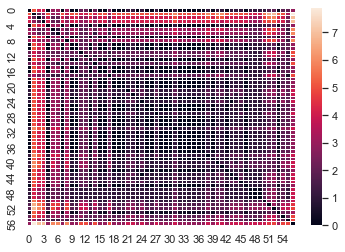

In [11]:
%time computeMetrics_handleJVM('prismdtmc/oscillatorsmu0.1.lambda1.tra','prismdtmc/oscillatorsmu0.1.lambda1.lab',1.0,printModel,printPartitions,False)


Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 62 blocks out of 62 variables
Computing the metrics
0.0 2.0 2.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0 0.98 0.02 1.0 1.0 1.0 0.99 0.01 1.0 1.0 1.96 0.04 0.99 0.01 0.98 0.02 1.0 1.0 1.0 1.0 1.98 0.02 0.98 0.02 1.0 1.0 1.0 0.98 0.02 1.98 0.02 0.98 0.02 1.0 1.0 1.0 1.0 1.0 2.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 
2.0 0.0 3.0004 3.0004 2.0008 3.01901 3.9408 2.0 1.99921 2.94079 2.0 2.0 2.0 1.0396 2.0 1.9608 1.9996 2.96978 2.96039 2.9796 2.0196 2.95059 2.0096 1.98079 1.99961 2.0 1.02039 2.0 2.0 2.0288 1.99 1.99999 2.0 2.00038 2.00019 1.0592 2.00038 2.00001 1.10741 1.9904 2.00019 2.0 2.0 2.0 2.01938 2.0096 2.0 2.99 2.00001 2.9904 2.0 2.9504 2.98 2.10741 1.98001 2.9804 1.9808 2.9804 2.0 3.0 2.0 2.99999 
2.0 3.0004 0.0 2.01059 3.0008 3.99 4.0 2.0 2.98 3.0 2.0 2.0 2.98 2.0196 3.0 2.9506 2.0096 3.0 3.0 3.96 2.04 2.99 2.01 2.00039 2.00001 2.98 2.0002 2.98 3.0 2.9995 2.0097 2.0097 2.000

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


 Completed
CPU times: user 1.41 s, sys: 794 ms, total: 2.2 s
Wall time: 24min 36s


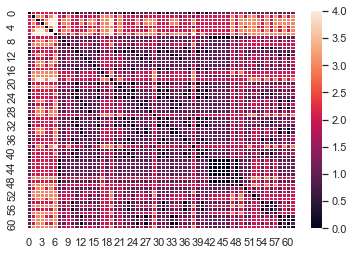

In [12]:
%time computeMetrics_handleJVM('prismdtmc/brpN2.MAX1.tra','prismdtmc/brpN2.MAX1.lab',1.0,printModel,printPartitions,False)

Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 20 blocks out of 20 variables
Computing the metrics
0.0 2.0 1.0 0.98 0.02 1.0 2.0 0.98 0.02 1.0 2.0 0.98 0.02 1.0 2.0 1.0 1.0 1.0 1.0 1.0 
2.0 0.0 2.0 2.0 2.0 2.0 2.0396 1.98079 1.99961 2.0 2.02039 1.98041 1.9996 2.0 2.02001 2.0 2.0 2.0 1.98 2.0 
1.0 2.0 0.0 1.0 1.0 0.98 2.0 1.0 1.0 0.98 2.0 1.0 1.0 0.98 2.0 0.02 0.02 0.02 1.0 1.0 
0.98 2.0 1.0 0.0 0.96 1.0 1.9804 0.0196 0.9604 1.0 1.9804 0.0196 0.9604 1.0 1.9804 1.0 1.0 1.0 0.0396 1.0 
0.02 2.0 1.0 0.96 0.0 1.0 1.9996 0.9604 0.0004 1.0 1.9996 0.9604 0.0004 1.0 1.9996 1.0 1.0 1.0 0.9804 1.0 
1.0 2.0 0.98 1.0 1.0 0.0 2.0 1.0 1.0 0.0196 2.0 1.0 1.0 0.0196 2.0 0.96 0.9604 0.9604 1.0 0.0396 
2.0 2.0396 2.0 1.9804 1.9996 2.0 0.0 1.9608 1.9992 2.0 2.0196 1.96119 1.99921 2.0 2.0196 2.0 2.0 2.0 1.9604 2.0 
0.98 1.98079 1.0 0.0196 0.9604 1.0 1.9608 0.0 0.96 1.0 1.96119 0.00039 0.96001 1.0 1.96119 1.0 1.0 1.0 0.02039 1.0 
0.02 1.99961 1.0 0.9

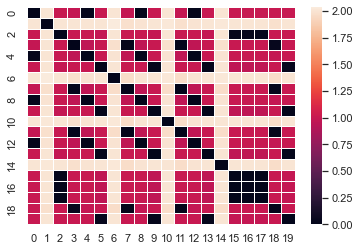

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1224, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


In [13]:
%time computeMetrics_handleJVM('prismdtmc/brpN1.MAX2.tra','prismdtmc/brpN1.MAX2.lab',1.0,printModel,printPartitions,False)

Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 44 blocks out of 44 variables
Computing the metrics
0.0 1.0 0.1 0.9 0.1 0.9 0.1 0.9 1.04 2.96 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
1.0 0.0 1.0 1.0 0.91 0.19 0.99 0.91 0.908 2.06 1.04 2.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
0.1 1.0 0.0 0.8 0.1 0.9 0.1 0.9 1.0166 2.879 0.9908 1.1 1.004 1.1 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
0.9 1.0 0.8 0.0 0.9 0.9 0.9 0.9 0.9446 2.231 0.9172 1.9 1.036 1.9 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 2.0 2.0 
0.1 0.91 0.1 0.9 0.0 0.8 0.08 0.88 0.998 2.87 1.00166 1.1 0.99908 1.01 1.0004 1.01 1.0 1.0 1.0 1.0 1.0 1.

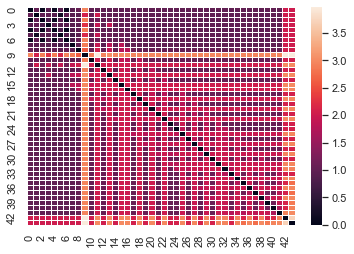

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1217, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [Errno 54] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/andrea/Documents/python_envs/env_research/lib/python3.9/site-packages/py4j/java_gateway.py", line 1228, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving


In [14]:
%time computeMetrics_handleJVM('prismdtmc/nandN1.K2.tra','prismdtmc/nandN1.K2.lab',1.0,printModel,printPartitions,False)

## Weighted Networks



HANDLING  dom_DeLaFuente_2019A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 339.0 292.0 309.0 260.0 368.0 
339.0 0.0 141.0 88.0 207.0 103.0 
292.0 141.0 0.0 155.0 196.0 170.0 
309.0 88.0 155.0 0.0 219.0 151.0 
260.0 207.0 196.0 219.0 0.0 132.0 
368.0 103.0 170.0 151.0 132.0 0.0 
Terminating JVM and ERODE
 Completed
CPU times: user 328 ms, sys: 202 ms, total: 531 ms
Wall time: 6.38 s


HANDLING  moviegalaxies_765A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 14 blocks out of 15 variables
Computing the metrics
0.0 3.0 74.0 65.0 23.0 6.0 4.0 60.0 10.0 4.0 84.0 4.0 3.0 51.0 3.0 
3.0 0.0 73.0 62.0 20.0 3.0 3.0 57.0 11.0 3.0 83.0 5.0 4.0 50.0 4.0 
74.0 73.0 0.0 61.0 73.0 72.0 76.0 52.0 64.0 72.0 66.0 74.0 75.0 53.0 75.0 
65.0 62.0 61.0 0.0 44.0 59.0 63.0 33.0 59.0 63.0 67.0 63.0 64.0 40.0 64.0 
23.0 20.0 73.0 4

ValueError: left cannot be >= right



HANDLING  dom_Archie_2006hA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 9 blocks out of 9 variables
Computing the metrics
0.0 9.0 3.0 10.0 4.0 8.0 8.0 7.0 10.0 
9.0 0.0 8.0 3.0 7.0 7.0 7.0 6.0 9.0 
3.0 8.0 0.0 9.0 3.0 7.0 7.0 6.0 9.0 
10.0 3.0 9.0 0.0 8.0 10.0 8.0 9.0 10.0 
4.0 7.0 3.0 8.0 0.0 8.0 4.0 7.0 6.0 
8.0 7.0 7.0 10.0 8.0 0.0 8.0 1.0 10.0 
8.0 7.0 7.0 8.0 4.0 8.0 0.0 7.0 2.0 
7.0 6.0 6.0 9.0 7.0 1.0 7.0 0.0 9.0 
10.0 9.0 9.0 10.0 6.0 10.0 2.0 9.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Ortius_1995A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 115.0 71.0 70.0 70.0 78.0 
115.0 0.0 48.0 55.0 59.0 53.0 
71.0 48.0 0.0 23.0 29.0 33.0 
70.0 55.0 23.0 0.0 28.0 24.0 
70.0 59.0 29.0 28.0 0.0 28.0 
78.0 53.0 33.0 24.0 28.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Bonanni_2017dA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 388.0 384.0 516.0 360.0 343.0 302.0 315.0 
388.0 0.0 164.0 258.0 170.0 133.0 142.0 255.0 
384.0 164.0 0.0 176.0 114.0 119.0 150.0 253.0 
516.0 258.0 176.0 0.0 270.0 283.0 278.0 417.0 
360.0 170.0 114.0 270.0 0.0 93.0 116.0 209.0 
343.0 133.0 119.0 283.0 93.0 0.0 41.0 194.0 
302.0 142.0 150.0 278.0 116.0 41.0 0.0 211.0 
315.0 255.0 253.0 417.0 209.0 194.0 211.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Blatrix_2004dA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 12.0 46.0 10.0 10.0 20.0 
12.0 0.0 44.0 10.0 10.0 22.0 
46.0 44.0 0.0 38.0 52.0 58.0 
10.0 10.0 38.0 0.0 16.0 30.0 
10.0 10.0 52.0 16.0 0.0 14.0 
20.0 22.0 58.0 30.0 14.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_BergstromFedigan_2010cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 10 blocks out of 10 variables
Computing the metrics
0.0 18.0 18.0 48.0 20.0 36.0 26.0 18.0 35.0 39.0 
18.0 0.0 22.0 56.0 22.0 30.0 26.0 18.0 39.0 35.0 
18.0 22.0 0.0 50.0 12.0 42.0 24.0 24.0 29.0 39.0 
48.0 56.0 50.0 0.0 40.0 56.0 56.0 54.0 47.0 57.0 
20.0 22.0 12.0 40.0 0.0 38.0 32.0 20.0 37.0 47.0 
36.0 30.0 42.0 56.0 38.0 0.0 22.0 26.0 33.0 19.0 
26.0 26.0 24.0 56.0 32.0 22.0 0.0 20.0 21.0 17.0 
18.0 18.0 24.0 54.0 20.0 26.0 20.0 0.0 33.0 31.0 
35.0 39.0 29.0 47.0 37.0 33.0 21.0 33.0 0.0 24.0 
39.0 35.0 39.0 57.0 47.0 19.0 17.0 31.0 24.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Oshea_1976A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 10 blocks out of 10 variables
Computing the metrics
0.0 36.0 60.0 40.0 58.0 52.0 38.0 48.0 15.0 41.0 
36.0 0.0 74.0 46.0 60.0 54.0 46.0 44.0 29.0 39.0 
60.0 74.0 0.0 62.0 56.0 50.0 72.0 66.0 63.0 67.0 
40.0 46.0 62.0 0.0 52.0 26.0 60.0 56.0 49.0 47.0 
58.0 60.0 56.0 52.0 0.0 56.0 70.0 60.0 63.0 57.0 
52.0 54.0 50.0 26.0 56.0 0.0 50.0 44.0 55.0 39.0 
38.0 46.0 72.0 60.0 70.0 50.0 0.0 26.0 31.0 33.0 
48.0 44.0 66.0 56.0 60.0 44.0 26.0 0.0 41.0 39.0 
15.0 29.0 63.0 49.0 63.0 55.0 31.0 41.0 0.0 40.0 
41.0 39.0 67.0 47.0 57.0 39.0 33.0 39.0 40.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Seyfarth_1976eA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 5.0 20.0 14.0 12.0 10.0 22.0 9.0 
5.0 0.0 15.0 11.0 11.0 11.0 23.0 8.0 
20.0 15.0 0.0 14.0 14.0 16.0 24.0 19.0 
14.0 11.0 14.0 0.0 8.0 8.0 24.0 7.0 
12.0 11.0 14.0 8.0 0.0 16.0 24.0 11.0 
10.0 11.0 16.0 8.0 16.0 0.0 24.0 9.0 
22.0 23.0 24.0 24.0 24.0 24.0 0.0 21.0 
9.0 8.0 19.0 7.0 11.0 9.0 21.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Wikberg_2013aA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 9.0 8.0 4.0 8.0 3.0 6.0 8.0 
9.0 0.0 9.0 13.0 9.0 12.0 9.0 9.0 
8.0 9.0 0.0 8.0 8.0 11.0 10.0 10.0 
4.0 13.0 8.0 0.0 10.0 5.0 10.0 10.0 
8.0 9.0 8.0 10.0 0.0 9.0 4.0 10.0 
3.0 12.0 11.0 5.0 9.0 0.0 5.0 7.0 
6.0 9.0 10.0 10.0 4.0 5.0 0.0 6.0 
8.0 9.0 10.0 10.0 10.0 7.0 6.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Collias_1951bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 14.0 19.0 24.0 10.0 8.0 14.0 5.0 
14.0 0.0 27.0 20.0 18.0 18.0 6.0 9.0 
19.0 27.0 0.0 29.0 21.0 21.0 27.0 20.0 
24.0 20.0 29.0 0.0 26.0 28.0 18.0 19.0 
10.0 18.0 21.0 26.0 0.0 8.0 18.0 11.0 
8.0 18.0 21.0 28.0 8.0 0.0 18.0 9.0 
14.0 6.0 27.0 18.0 18.0 18.0 0.0 11.0 
5.0 9.0 20.0 19.0 11.0 9.0 11.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Langbein_2004dA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 9 blocks out of 9 variables
Computing the metrics
0.0 15.0 15.0 13.0 8.0 14.0 13.0 16.0 17.0 
15.0 0.0 12.0 14.0 11.0 13.0 14.0 17.0 18.0 
15.0 12.0 0.0 14.0 9.0 7.0 6.0 11.0 14.0 
13.0 14.0 14.0 0.0 9.0 11.0 10.0 7.0 20.0 
8.0 11.0 9.0 9.0 0.0 6.0 7.0 10.0 17.0 
14.0 13.0 7.0 11.0 6.0 0.0 3.0 8.0 21.0 
13.0 14.0 6.0 10.0 7.0 3.0 0.0 9.0 20.0 
16.0 17.0 11.0 7.0 10.0 8.0 9.0 0.0 19.0 
17.0 18.0 14.0 20.0 17.0 21.0 20.0 19.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_5A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 5 blocks out of 9 variables
Computing the metrics
0.0 18.0 18.0 18.0 19.0 23.0 19.0 19.0 18.0 
18.0 0.0 8.0 8.0 1.0 5.0 1.0 1.0 0.0 
18.0 8.0 0.0 0.0 7.0 5.0 7.0 7.0 8.0 
18.0 8.0 0.0 0.0 7.0 5.0 7.0 7.0 8.0 
19.0 1.0 7.0 7.0 0.0 4.0 0.0 0.0 1.0 
23.0 5.0 5.0 5.0 4.0 0.0 4.0 4.0 5.0 
19.0 1.0 7.0 7.0 0.0 4.0 0.0 0.0 1.0 
19.0 1.0 7.0 7.0 0.0 4.0 0.0 0.0 1.0 
18.0 0.0 8.0 8.0 1.0 5.0 1.0 1.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Ito_1993aA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 62.0 123.0 102.0 38.0 55.0 79.0 63.0 
62.0 0.0 113.0 66.0 50.0 39.0 65.0 51.0 
123.0 113.0 0.0 131.0 99.0 104.0 104.0 110.0 
102.0 66.0 131.0 0.0 88.0 75.0 73.0 107.0 
38.0 50.0 99.0 88.0 0.0 39.0 69.0 47.0 
55.0 39.0 104.0 75.0 39.0 0.0 56.0 38.0 
79.0 65.0 104.0 73.0 69.0 56.0 0.0 58.0 
63.0 51.0 110.0 107.0 47.0 38.0 58.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Lee_1979bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 40.0 44.0 76.0 56.0 59.0 45.0 64.0 
40.0 0.0 12.0 54.0 54.0 33.0 49.0 34.0 
44.0 12.0 0.0 56.0 56.0 25.0 45.0 32.0 
76.0 54.0 56.0 0.0 98.0 57.0 73.0 44.0 
56.0 54.0 56.0 98.0 0.0 77.0 49.0 62.0 
59.0 33.0 25.0 57.0 77.0 0.0 66.0 39.0 
45.0 49.0 45.0 73.0 49.0 66.0 0.0 31.0 
64.0 34.0 32.0 44.0 62.0 39.0 31.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Farentinos_1972fA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 10 blocks out of 10 variables
Computing the metrics
0.0 217.0 244.0 288.0 247.0 228.0 227.0 231.0 223.0 229.0 
217.0 0.0 41.0 133.0 52.0 39.0 32.0 40.0 18.0 42.0 
244.0 41.0 0.0 118.0 31.0 52.0 31.0 53.0 29.0 53.0 
288.0 133.0 118.0 0.0 109.0 152.0 119.0 151.0 137.0 151.0 
247.0 52.0 31.0 109.0 0.0 77.0 54.0 76.0 54.0 76.0 
228.0 39.0 52.0 152.0 77.0 0.0 41.0 3.0 29.0 3.0 
227.0 32.0 31.0 119.0 54.0 41.0 0.0 42.0 24.0 42.0 
231.0 40.0 53.0 151.0 76.0 3.0 42.0 0.0 30.0 2.0 
223.0 18.0 29.0 137.0 54.0 29.0 24.0 30.0 0.0 30.0 
229.0 42.0 53.0 151.0 76.0 3.0 42.0 2.0 30.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_435A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 18 blocks out of 27 variables
Computing the metrics
0.0 7.0 2.0 11.0 58.0 3.0 2.0 7.0 2.0 4.0 11.0 2.0 2.0 4.0 7.0 3.0 2.0 11.0 9.0 2.0 4.0 3.0 2.0 7.0 2.0 9.0 15.0 
7.0 0.0 5.0 8.0 57.0 6.0 5.0 8.0 5.0 5.0 12.0 7.0 5.0 7.0 10.0 8.0 5.0 12.0 10.0 5.0 7.0 4.0 5.0 8.0 5.0 8.0 16.0 
2.0 5.0 0.0 9.0 60.0 1.0 0.0 5.0 0.0 2.0 9.0 2.0 0.0 2.0 5.0 3.0 0.0 9.0 7.0 0.0 2.0 1.0 0.0 5.0 0.0 7.0 13.0 
11.0 8.0 9.0 0.0 61.0 10.0 9.0 12.0 9.0 7.0 8.0 11.0 9.0 11.0 14.0 12.0 9.0 8.0 6.0 9.0 11.0 10.0 9.0 8.0 9.0 10.0 12.0 
58.0 57.0 60.0 61.0 0.0 61.0 60.0 57.0 60.0 62.0 61.0 58.0 60.0 58.0 57.0 57.0 60.0 61.0 67.0 60.0 58.0 59.0 60.0 61.0 60.0 59.0 67.0 
3.0 6.0 1.0 10.0 61.0 0.0 1.0 6.0 1.0 3.0 10.0 3.0 1.0 3.0 6.0 4.0 1.0 10.0 8.0 1.0 3.0 2.0 1.0 6.0 1.0 8.0 14.0 
2.0 5.0 0.0 9.0 60.0 1.0 0.0 5.0 0.0 2.0 9.0 2.0 0.0 2.0 5.0 3.0 0.0 9.0 7.0 0.0 2.0 1.0 0.0 5.0 0

ValueError: left cannot be >= right



HANDLING  dom_White_2007cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 5 blocks out of 6 variables
Computing the metrics
0.0 3.0 6.0 3.0 7.0 7.0 
3.0 0.0 5.0 0.0 6.0 6.0 
6.0 5.0 0.0 5.0 9.0 9.0 
3.0 0.0 5.0 0.0 6.0 6.0 
7.0 6.0 9.0 6.0 0.0 6.0 
7.0 6.0 9.0 6.0 6.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Alados_1992cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 7 blocks out of 7 variables
Computing the metrics
0.0 76.0 88.0 51.0 76.0 67.0 68.0 
76.0 0.0 84.0 27.0 62.0 49.0 86.0 
88.0 84.0 0.0 93.0 64.0 73.0 88.0 
51.0 27.0 93.0 0.0 59.0 40.0 91.0 
76.0 62.0 64.0 59.0 0.0 31.0 98.0 
67.0 49.0 73.0 40.0 31.0 0.0 93.0 
68.0 86.0 88.0 91.0 98.0 93.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_634A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 12 blocks out of 15 variables
Computing the metrics
0.0 6.0 6.0 5.0 8.0 6.0 6.0 33.0 6.0 5.0 5.0 6.0 5.0 5.0 6.0 
6.0 0.0 6.0 7.0 10.0 6.0 8.0 31.0 8.0 5.0 7.0 6.0 7.0 7.0 6.0 
6.0 6.0 0.0 3.0 12.0 4.0 6.0 33.0 4.0 3.0 3.0 2.0 3.0 5.0 4.0 
5.0 7.0 3.0 0.0 11.0 1.0 7.0 34.0 1.0 4.0 0.0 1.0 0.0 4.0 1.0 
8.0 10.0 12.0 11.0 0.0 10.0 10.0 35.0 10.0 11.0 11.0 12.0 11.0 7.0 10.0 
6.0 6.0 4.0 1.0 10.0 0.0 8.0 33.0 2.0 5.0 1.0 2.0 1.0 5.0 0.0 
6.0 8.0 6.0 7.0 10.0 8.0 0.0 33.0 8.0 5.0 7.0 6.0 7.0 5.0 8.0 
33.0 31.0 33.0 34.0 35.0 33.0 33.0 0.0 33.0 32.0 34.0 33.0 34.0 38.0 33.0 
6.0 8.0 4.0 1.0 10.0 2.0 8.0 33.0 0.0 5.0 1.0 2.0 1.0 5.0 2.0 
5.0 5.0 3.0 4.0 11.0 5.0 5.0 32.0 5.0 0.0 4.0 3.0 4.0 6.0 5.0 
5.0 7.0 3.0 0.0 11.0 1.0 7.0 34.0 1.0 4.0 0.0 1.0 0.0 4.0 1.0 
6.0 6.0 2.0 1.0 12.0 2.0 6.0 33.0 2.0 3.0 1.0 0.0 1.0 5.0 2.0 
5.0 7.0 3.0 0.0 11.0 1.0 7.0 34

ValueError: left cannot be >= right



HANDLING  dom_SomersNel_1998bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 36.0 34.0 56.0 32.0 35.0 23.0 36.0 
36.0 0.0 44.0 36.0 34.0 41.0 37.0 64.0 
34.0 44.0 0.0 30.0 24.0 23.0 27.0 48.0 
56.0 36.0 30.0 0.0 40.0 45.0 53.0 68.0 
32.0 34.0 24.0 40.0 0.0 11.0 17.0 54.0 
35.0 41.0 23.0 45.0 11.0 0.0 16.0 53.0 
23.0 37.0 27.0 53.0 17.0 16.0 0.0 43.0 
36.0 64.0 48.0 68.0 54.0 53.0 43.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Poisbleau_2005cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 7 blocks out of 7 variables
Computing the metrics
0.0 39.0 91.0 56.0 51.0 82.0 91.0 
39.0 0.0 78.0 43.0 42.0 85.0 76.0 
91.0 78.0 0.0 65.0 106.0 111.0 104.0 
56.0 43.0 65.0 0.0 65.0 88.0 75.0 
51.0 42.0 106.0 65.0 0.0 91.0 44.0 
82.0 85.0 111.0 88.0 91.0 0.0 87.0 
91.0 76.0 104.0 75.0 44.0 87.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Archie_2006cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 21.0 21.0 25.0 20.0 23.0 
21.0 0.0 14.0 14.0 17.0 14.0 
21.0 14.0 0.0 20.0 17.0 4.0 
25.0 14.0 20.0 0.0 21.0 20.0 
20.0 17.0 17.0 21.0 0.0 13.0 
23.0 14.0 4.0 20.0 13.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_819A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 9 variables
Computing the metrics
0.0 1.0 43.0 53.0 5.0 19.0 0.0 37.0 1.0 
1.0 0.0 44.0 52.0 4.0 18.0 1.0 36.0 2.0 
43.0 44.0 0.0 50.0 42.0 38.0 43.0 34.0 42.0 
53.0 52.0 50.0 0.0 50.0 46.0 53.0 50.0 52.0 
5.0 4.0 42.0 50.0 0.0 16.0 5.0 34.0 4.0 
19.0 18.0 38.0 46.0 16.0 0.0 19.0 30.0 20.0 
0.0 1.0 43.0 53.0 5.0 19.0 0.0 37.0 1.0 
37.0 36.0 34.0 50.0 34.0 30.0 37.0 0.0 36.0 
1.0 2.0 42.0 52.0 4.0 20.0 1.0 36.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_SatohOhkawara_2008cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 10 blocks out of 10 variables
Computing the metrics
0.0 73.0 63.0 67.0 67.0 74.0 77.0 63.0 77.0 71.0 
73.0 0.0 46.0 46.0 46.0 39.0 38.0 50.0 36.0 44.0 
63.0 46.0 0.0 20.0 8.0 13.0 14.0 8.0 16.0 18.0 
67.0 46.0 20.0 0.0 12.0 15.0 16.0 12.0 18.0 10.0 
67.0 46.0 8.0 12.0 0.0 9.0 10.0 4.0 12.0 10.0 
74.0 39.0 13.0 15.0 9.0 0.0 3.0 13.0 5.0 9.0 
77.0 38.0 14.0 16.0 10.0 3.0 0.0 14.0 4.0 8.0 
63.0 50.0 8.0 12.0 4.0 13.0 14.0 0.0 16.0 10.0 
77.0 36.0 16.0 18.0 12.0 5.0 4.0 16.0 0.0 8.0 
71.0 44.0 18.0 10.0 10.0 9.0 8.0 10.0 8.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_622A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 11 blocks out of 11 variables
Computing the metrics
0.0 24.0 23.0 23.0 24.0 22.0 25.0 45.0 24.0 23.0 38.0 
24.0 0.0 3.0 13.0 2.0 10.0 13.0 35.0 4.0 21.0 24.0 
23.0 3.0 0.0 12.0 1.0 11.0 12.0 36.0 3.0 22.0 25.0 
23.0 13.0 12.0 0.0 11.0 21.0 10.0 38.0 9.0 24.0 23.0 
24.0 2.0 1.0 11.0 0.0 10.0 11.0 37.0 2.0 23.0 24.0 
22.0 10.0 11.0 21.0 10.0 0.0 21.0 35.0 12.0 25.0 30.0 
25.0 13.0 12.0 10.0 11.0 21.0 0.0 34.0 9.0 24.0 27.0 
45.0 35.0 36.0 38.0 37.0 35.0 34.0 0.0 39.0 40.0 47.0 
24.0 4.0 3.0 9.0 2.0 12.0 9.0 39.0 0.0 23.0 26.0 
23.0 21.0 22.0 24.0 23.0 25.0 24.0 40.0 23.0 0.0 41.0 
38.0 24.0 25.0 23.0 24.0 30.0 27.0 47.0 26.0 41.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_602A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 15 blocks out of 23 variables
Computing the metrics
0.0 2.0 2.0 6.0 6.0 5.0 3.0 3.0 0.0 6.0 2.0 21.0 37.0 2.0 3.0 2.0 6.0 2.0 34.0 2.0 1.0 5.0 1.0 
2.0 0.0 2.0 4.0 4.0 3.0 1.0 1.0 2.0 6.0 2.0 19.0 39.0 2.0 1.0 0.0 6.0 2.0 34.0 0.0 1.0 5.0 1.0 
2.0 2.0 0.0 4.0 4.0 3.0 1.0 1.0 2.0 4.0 0.0 19.0 37.0 2.0 3.0 2.0 6.0 0.0 36.0 2.0 3.0 5.0 3.0 
6.0 4.0 4.0 0.0 0.0 3.0 3.0 3.0 6.0 6.0 4.0 19.0 35.0 6.0 5.0 4.0 6.0 4.0 34.0 4.0 5.0 5.0 5.0 
6.0 4.0 4.0 0.0 0.0 3.0 3.0 3.0 6.0 6.0 4.0 19.0 35.0 6.0 5.0 4.0 6.0 4.0 34.0 4.0 5.0 5.0 5.0 
5.0 3.0 3.0 3.0 3.0 0.0 2.0 2.0 5.0 7.0 3.0 20.0 36.0 5.0 4.0 3.0 7.0 3.0 33.0 3.0 4.0 6.0 4.0 
3.0 1.0 1.0 3.0 3.0 2.0 0.0 0.0 3.0 5.0 1.0 18.0 38.0 3.0 2.0 1.0 5.0 1.0 35.0 1.0 2.0 4.0 2.0 
3.0 1.0 1.0 3.0 3.0 2.0 0.0 0.0 3.0 5.0 1.0 18.0 38.0 3.0 2.0 1.0 5.0 1.0 35.0 1.0 2.0 4.0 2.0 
0.0 2.0 2.0 6.0 6.0 5.0 3.0 3.0 0.0 6.0 

ValueError: left cannot be >= right



HANDLING  dom_Miller_2010cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 76.0 94.0 70.0 54.0 66.0 
76.0 0.0 62.0 16.0 54.0 52.0 
94.0 62.0 0.0 54.0 86.0 102.0 
70.0 16.0 54.0 0.0 62.0 56.0 
54.0 54.0 86.0 62.0 0.0 44.0 
66.0 52.0 102.0 56.0 44.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_317A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 16 blocks out of 19 variables
Computing the metrics
0.0 8.0 4.0 9.0 9.0 6.0 8.0 5.0 6.0 24.0 4.0 6.0 15.0 8.0 7.0 17.0 7.0 7.0 7.0 
8.0 0.0 4.0 9.0 9.0 4.0 4.0 5.0 4.0 24.0 6.0 4.0 13.0 4.0 3.0 15.0 3.0 5.0 3.0 
4.0 4.0 0.0 5.0 5.0 2.0 4.0 3.0 2.0 22.0 2.0 2.0 11.0 4.0 3.0 13.0 3.0 3.0 3.0 
9.0 9.0 5.0 0.0 6.0 5.0 9.0 8.0 7.0 21.0 7.0 7.0 12.0 9.0 8.0 12.0 8.0 6.0 8.0 
9.0 9.0 5.0 6.0 0.0 5.0 9.0 8.0 7.0 25.0 7.0 7.0 8.0 9.0 8.0 16.0 8.0 6.0 8.0 
6.0 4.0 2.0 5.0 5.0 0.0 4.0 5.0 4.0 24.0 4.0 4.0 9.0 4.0 5.0 15.0 3.0 1.0 5.0 
8.0 4.0 4.0 9.0 9.0 4.0 0.0 5.0 4.0 24.0 6.0 4.0 11.0 0.0 5.0 13.0 1.0 5.0 5.0 
5.0 5.0 3.0 8.0 8.0 5.0 5.0 0.0 1.0 19.0 3.0 1.0 14.0 5.0 4.0 14.0 4.0 6.0 4.0 
6.0 4.0 2.0 7.0 7.0 4.0 4.0 1.0 0.0 20.0 2.0 0.0 13.0 4.0 3.0 13.0 3.0 5.0 3.0 
24.0 24.0 22.0 21.0 25.0 24.0 24.0 19.0 20.0 0.0 22.0 20.0 27.0 24.0 23.0 23.0 23.0 23.0 2

ValueError: left cannot be >= right



HANDLING  dom_Robbins_2008A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 100.0 107.0 121.0 109.0 108.0 109.0 104.0 
100.0 0.0 25.0 43.0 23.0 16.0 25.0 20.0 
107.0 25.0 0.0 24.0 20.0 17.0 16.0 25.0 
121.0 43.0 24.0 0.0 30.0 29.0 30.0 33.0 
109.0 23.0 20.0 30.0 0.0 9.0 10.0 11.0 
108.0 16.0 17.0 29.0 9.0 0.0 13.0 12.0 
109.0 25.0 16.0 30.0 10.0 13.0 0.0 19.0 
104.0 20.0 25.0 33.0 11.0 12.0 19.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Monnin_1999A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 103.0 118.0 62.0 47.0 56.0 
103.0 0.0 83.0 75.0 64.0 49.0 
118.0 83.0 0.0 88.0 75.0 72.0 
62.0 75.0 88.0 0.0 25.0 32.0 
47.0 64.0 75.0 25.0 0.0 17.0 
56.0 49.0 72.0 32.0 17.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Yasukawa_1983gA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 124.0 146.0 101.0 134.0 129.0 
124.0 0.0 110.0 27.0 48.0 69.0 
146.0 110.0 0.0 117.0 114.0 107.0 
101.0 27.0 117.0 0.0 65.0 78.0 
134.0 48.0 114.0 65.0 0.0 51.0 
129.0 69.0 107.0 78.0 51.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Wikberg_2013fA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 10 blocks out of 10 variables
Computing the metrics
0.0 15.0 13.0 9.0 16.0 12.0 6.0 15.0 9.0 15.0 
15.0 0.0 22.0 18.0 25.0 19.0 19.0 20.0 22.0 24.0 
13.0 22.0 0.0 10.0 7.0 9.0 7.0 6.0 8.0 12.0 
9.0 18.0 10.0 0.0 13.0 7.0 5.0 12.0 8.0 12.0 
16.0 25.0 7.0 13.0 0.0 10.0 10.0 9.0 7.0 5.0 
12.0 19.0 9.0 7.0 10.0 0.0 8.0 9.0 9.0 9.0 
6.0 19.0 7.0 5.0 10.0 8.0 0.0 11.0 7.0 11.0 
15.0 20.0 6.0 12.0 9.0 9.0 11.0 0.0 10.0 12.0 
9.0 22.0 8.0 8.0 7.0 9.0 7.0 10.0 0.0 8.0 
15.0 24.0 12.0 12.0 5.0 9.0 11.0 12.0 8.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Blatrix_2004cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 12 blocks out of 12 variables
Computing the metrics
0.0 120.0 99.0 87.0 51.0 17.0 12.0 14.0 11.0 16.0 15.0 48.0 
120.0 0.0 105.0 115.0 105.0 125.0 124.0 122.0 121.0 126.0 125.0 112.0 
99.0 105.0 0.0 70.0 92.0 104.0 107.0 109.0 106.0 109.0 108.0 89.0 
87.0 115.0 70.0 0.0 66.0 90.0 93.0 91.0 92.0 95.0 94.0 59.0 
51.0 105.0 92.0 66.0 0.0 58.0 61.0 57.0 62.0 63.0 64.0 23.0 
17.0 125.0 104.0 90.0 58.0 0.0 13.0 13.0 10.0 13.0 12.0 53.0 
12.0 124.0 107.0 93.0 61.0 13.0 0.0 8.0 5.0 4.0 3.0 56.0 
14.0 122.0 109.0 91.0 57.0 13.0 8.0 0.0 7.0 6.0 7.0 54.0 
11.0 121.0 106.0 92.0 62.0 10.0 5.0 7.0 0.0 7.0 6.0 55.0 
16.0 126.0 109.0 95.0 63.0 13.0 4.0 6.0 7.0 0.0 1.0 56.0 
15.0 125.0 108.0 94.0 64.0 12.0 3.0 7.0 6.0 1.0 0.0 55.0 
48.0 112.0 89.0 59.0 23.0 53.0 56.0 54.0 55.0 56.0 55.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Trebouet_2019bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 7 blocks out of 7 variables
Computing the metrics
0.0 15.0 13.0 12.0 11.0 13.0 14.0 
15.0 0.0 4.0 5.0 6.0 4.0 3.0 
13.0 4.0 0.0 7.0 4.0 8.0 7.0 
12.0 5.0 7.0 0.0 5.0 1.0 2.0 
11.0 6.0 4.0 5.0 0.0 6.0 5.0 
13.0 4.0 8.0 1.0 6.0 0.0 1.0 
14.0 3.0 7.0 2.0 5.0 1.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Seyfarth_1976bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 50.0 48.0 57.0 69.0 57.0 53.0 58.0 
50.0 0.0 42.0 55.0 27.0 33.0 23.0 32.0 
48.0 42.0 0.0 51.0 37.0 37.0 29.0 28.0 
57.0 55.0 51.0 0.0 42.0 24.0 40.0 39.0 
69.0 27.0 37.0 42.0 0.0 28.0 24.0 19.0 
57.0 33.0 37.0 24.0 28.0 0.0 28.0 25.0 
53.0 23.0 29.0 40.0 24.0 28.0 0.0 29.0 
58.0 32.0 28.0 39.0 19.0 25.0 29.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_141A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 11 blocks out of 16 variables
Computing the metrics
0.0 24.0 23.0 21.0 23.0 22.0 23.0 22.0 23.0 26.0 22.0 22.0 26.0 23.0 22.0 22.0 
24.0 0.0 17.0 17.0 17.0 18.0 17.0 18.0 17.0 26.0 18.0 18.0 12.0 19.0 18.0 18.0 
23.0 17.0 0.0 2.0 2.0 3.0 6.0 1.0 0.0 25.0 1.0 1.0 17.0 4.0 3.0 1.0 
21.0 17.0 2.0 0.0 2.0 5.0 6.0 1.0 2.0 27.0 1.0 1.0 17.0 4.0 5.0 1.0 
23.0 17.0 2.0 2.0 0.0 5.0 4.0 1.0 2.0 25.0 1.0 1.0 17.0 2.0 5.0 1.0 
22.0 18.0 3.0 5.0 5.0 0.0 5.0 4.0 3.0 22.0 4.0 4.0 18.0 5.0 0.0 4.0 
23.0 17.0 6.0 6.0 4.0 5.0 0.0 5.0 6.0 21.0 5.0 5.0 17.0 2.0 5.0 5.0 
22.0 18.0 1.0 1.0 1.0 4.0 5.0 0.0 1.0 26.0 0.0 0.0 18.0 3.0 4.0 0.0 
23.0 17.0 0.0 2.0 2.0 3.0 6.0 1.0 0.0 25.0 1.0 1.0 17.0 4.0 3.0 1.0 
26.0 26.0 25.0 27.0 25.0 22.0 21.0 26.0 25.0 0.0 26.0 26.0 26.0 23.0 22.0 26.0 
22.0 18.0 1.0 1.0 1.0 4.0 5.0 0.0 1.0 26.0 0.0 0.0 18.0 3.0 4.0 0.0 
22.0 18.0 1.0 1.

ValueError: left cannot be >= right



HANDLING  dom_Harcourt_1979A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 7 blocks out of 7 variables
Computing the metrics
0.0 18.0 14.0 13.0 20.0 16.0 34.0 
18.0 0.0 10.0 5.0 6.0 4.0 20.0 
14.0 10.0 0.0 7.0 16.0 14.0 30.0 
13.0 5.0 7.0 0.0 9.0 9.0 25.0 
20.0 6.0 16.0 9.0 0.0 8.0 18.0 
16.0 4.0 14.0 9.0 8.0 0.0 20.0 
34.0 20.0 30.0 25.0 18.0 20.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Vervaecke_2010dA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 26.0 31.0 23.0 10.0 18.0 33.0 23.0 
26.0 0.0 21.0 19.0 28.0 16.0 21.0 29.0 
31.0 21.0 0.0 22.0 31.0 23.0 16.0 28.0 
23.0 19.0 22.0 0.0 21.0 19.0 16.0 16.0 
10.0 28.0 31.0 21.0 0.0 20.0 31.0 17.0 
18.0 16.0 23.0 19.0 20.0 0.0 29.0 19.0 
33.0 21.0 16.0 16.0 31.0 29.0 0.0 22.0 
23.0 29.0 28.0 16.0 17.0 19.0 22.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Lahti_1994bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 57.0 47.0 71.0 52.0 90.0 47.0 58.0 
57.0 0.0 56.0 58.0 79.0 95.0 24.0 63.0 
47.0 56.0 0.0 62.0 79.0 79.0 54.0 55.0 
71.0 58.0 62.0 0.0 85.0 77.0 68.0 95.0 
52.0 79.0 79.0 85.0 0.0 120.0 69.0 86.0 
90.0 95.0 79.0 77.0 120.0 0.0 105.0 124.0 
47.0 24.0 54.0 68.0 69.0 105.0 0.0 45.0 
58.0 63.0 55.0 95.0 86.0 124.0 45.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_911A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 15 blocks out of 16 variables
Computing the metrics
0.0 7.0 20.0 6.0 5.0 9.0 7.0 16.0 3.0 28.0 5.0 63.0 3.0 5.0 43.0 2.0 
7.0 0.0 13.0 9.0 10.0 8.0 12.0 15.0 6.0 23.0 10.0 66.0 8.0 8.0 40.0 7.0 
20.0 13.0 0.0 18.0 21.0 17.0 19.0 24.0 19.0 22.0 21.0 71.0 21.0 21.0 33.0 20.0 
6.0 9.0 18.0 0.0 7.0 5.0 3.0 18.0 5.0 30.0 7.0 63.0 5.0 9.0 47.0 4.0 
5.0 10.0 21.0 7.0 0.0 10.0 8.0 17.0 4.0 29.0 0.0 64.0 2.0 8.0 44.0 3.0 
9.0 8.0 17.0 5.0 10.0 0.0 6.0 15.0 6.0 29.0 10.0 64.0 8.0 10.0 46.0 7.0 
7.0 12.0 19.0 3.0 8.0 6.0 0.0 17.0 6.0 31.0 8.0 62.0 6.0 10.0 46.0 5.0 
16.0 15.0 24.0 18.0 17.0 15.0 17.0 0.0 15.0 26.0 17.0 59.0 17.0 13.0 41.0 16.0 
3.0 6.0 19.0 5.0 4.0 6.0 6.0 15.0 0.0 27.0 4.0 66.0 2.0 4.0 44.0 1.0 
28.0 23.0 22.0 30.0 29.0 29.0 31.0 26.0 27.0 0.0 29.0 63.0 29.0 25.0 43.0 28.0 
5.0 10.0 21.0 7.0 0.0 10.0 8.0 17.0 4.0 29.0 0.0 64.0 2.0 8.0 44.0 3

ValueError: left cannot be >= right



HANDLING  moviegalaxies_17A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 16 blocks out of 22 variables
Computing the metrics
0.0 7.0 6.0 11.0 10.0 5.0 9.0 7.0 7.0 10.0 9.0 8.0 6.0 3.0 4.0 3.0 6.0 6.0 6.0 6.0 7.0 60.0 
7.0 0.0 1.0 8.0 11.0 2.0 12.0 2.0 0.0 11.0 6.0 3.0 1.0 10.0 5.0 4.0 1.0 1.0 1.0 1.0 2.0 53.0 
6.0 1.0 0.0 7.0 10.0 1.0 11.0 1.0 1.0 10.0 5.0 2.0 0.0 9.0 4.0 3.0 0.0 0.0 0.0 0.0 1.0 54.0 
11.0 8.0 7.0 0.0 9.0 6.0 8.0 8.0 8.0 7.0 4.0 7.0 7.0 12.0 7.0 8.0 7.0 7.0 7.0 7.0 6.0 49.0 
10.0 11.0 10.0 9.0 0.0 9.0 7.0 9.0 11.0 8.0 7.0 8.0 10.0 13.0 6.0 7.0 10.0 10.0 10.0 10.0 11.0 50.0 
5.0 2.0 1.0 6.0 9.0 0.0 10.0 2.0 2.0 9.0 4.0 3.0 1.0 8.0 3.0 2.0 1.0 1.0 1.0 1.0 2.0 55.0 
9.0 12.0 11.0 8.0 7.0 10.0 0.0 12.0 12.0 9.0 8.0 11.0 11.0 10.0 7.0 8.0 11.0 11.0 11.0 11.0 10.0 51.0 
7.0 2.0 1.0 8.0 9.0 2.0 12.0 0.0 2.0 11.0 6.0 3.0 1.0 10.0 5.0 4.0 1.0 1.0 1.0 1.0 2.0 53.0 
7.0 0.0 1.0 8.0 11.0 2.0 12.0 2.0 0.0 11.0 6.0 3.

ValueError: left cannot be >= right



HANDLING  dom_David_2003aA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 7 blocks out of 7 variables
Computing the metrics
0.0 9.0 19.0 11.0 16.0 13.0 14.0 
9.0 0.0 24.0 12.0 23.0 14.0 13.0 
19.0 24.0 0.0 16.0 21.0 22.0 19.0 
11.0 12.0 16.0 0.0 11.0 14.0 9.0 
16.0 23.0 21.0 11.0 0.0 17.0 12.0 
13.0 14.0 22.0 14.0 17.0 0.0 7.0 
14.0 13.0 19.0 9.0 12.0 7.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Pardi_1948bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 10 blocks out of 10 variables
Computing the metrics
0.0 174.0 164.0 155.0 150.0 141.0 158.0 158.0 165.0 163.0 
174.0 0.0 94.0 95.0 80.0 83.0 100.0 102.0 111.0 113.0 
164.0 94.0 0.0 89.0 106.0 121.0 110.0 110.0 125.0 117.0 
155.0 95.0 89.0 0.0 35.0 42.0 47.0 39.0 48.0 48.0 
150.0 80.0 106.0 35.0 0.0 29.0 44.0 36.0 45.0 43.0 
141.0 83.0 121.0 42.0 29.0 0.0 35.0 31.0 38.0 40.0 
158.0 100.0 110.0 47.0 44.0 35.0 0.0 16.0 15.0 17.0 
158.0 102.0 110.0 39.0 36.0 31.0 16.0 0.0 15.0 13.0 
165.0 111.0 125.0 48.0 45.0 38.0 15.0 15.0 0.0 8.0 
163.0 113.0 117.0 48.0 43.0 40.0 17.0 13.0 8.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Vervaecke_2000A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 59.0 126.0 363.0 455.0 443.0 
59.0 0.0 83.0 304.0 412.0 422.0 
126.0 83.0 0.0 347.0 373.0 389.0 
363.0 304.0 347.0 0.0 624.0 656.0 
455.0 412.0 373.0 624.0 0.0 490.0 
443.0 422.0 389.0 656.0 490.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Paoli_2006A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 195.0 140.0 129.0 166.0 151.0 136.0 119.0 
195.0 0.0 85.0 98.0 117.0 108.0 101.0 120.0 
140.0 85.0 0.0 67.0 78.0 69.0 58.0 81.0 
129.0 98.0 67.0 0.0 103.0 26.0 15.0 54.0 
166.0 117.0 78.0 103.0 0.0 97.0 110.0 81.0 
151.0 108.0 69.0 26.0 97.0 0.0 21.0 52.0 
136.0 101.0 58.0 15.0 110.0 21.0 0.0 61.0 
119.0 120.0 81.0 54.0 81.0 52.0 61.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_814A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 1 blocks out of 2 variables
Computing the metrics
0.0 0.0 
0.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Setchell_2005bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 299.0 191.0 142.0 179.0 115.0 218.0 104.0 
299.0 0.0 336.0 263.0 390.0 250.0 301.0 299.0 
191.0 336.0 0.0 215.0 312.0 224.0 201.0 249.0 
142.0 263.0 215.0 0.0 255.0 147.0 194.0 184.0 
179.0 390.0 312.0 255.0 0.0 186.0 301.0 161.0 
115.0 250.0 224.0 147.0 186.0 0.0 227.0 109.0 
218.0 301.0 201.0 194.0 301.0 227.0 0.0 230.0 
104.0 299.0 249.0 184.0 161.0 109.0 230.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Hass_1991bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 12 blocks out of 13 variables
Computing the metrics
0.0 61.0 82.0 70.0 50.0 66.0 64.0 64.0 66.0 61.0 57.0 65.0 65.0 
61.0 0.0 67.0 63.0 37.0 27.0 39.0 31.0 35.0 38.0 26.0 40.0 40.0 
82.0 67.0 0.0 88.0 78.0 76.0 60.0 72.0 78.0 79.0 85.0 83.0 83.0 
70.0 63.0 88.0 0.0 50.0 56.0 74.0 60.0 64.0 65.0 47.0 69.0 69.0 
50.0 37.0 78.0 50.0 0.0 38.0 46.0 38.0 36.0 37.0 41.0 41.0 41.0 
66.0 27.0 76.0 56.0 38.0 0.0 34.0 12.0 8.0 13.0 27.0 13.0 13.0 
64.0 39.0 60.0 74.0 46.0 34.0 0.0 30.0 34.0 33.0 47.0 33.0 33.0 
64.0 31.0 72.0 60.0 38.0 12.0 30.0 0.0 6.0 11.0 35.0 11.0 11.0 
66.0 35.0 78.0 64.0 36.0 8.0 34.0 6.0 0.0 5.0 35.0 5.0 5.0 
61.0 38.0 79.0 65.0 37.0 13.0 33.0 11.0 5.0 0.0 40.0 4.0 4.0 
57.0 26.0 85.0 47.0 41.0 27.0 47.0 35.0 35.0 40.0 0.0 40.0 40.0 
65.0 40.0 83.0 69.0 41.0 13.0 33.0 11.0 5.0 4.0 40.0 0.0 0.0 
65.0 40.0 83.0 69.0 41.0 13.0 33.0 11.0 5.0 

ValueError: left cannot be >= right



HANDLING  dom_Blatrix_2004bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 31.0 11.0 14.0 8.0 5.0 9.0 10.0 
31.0 0.0 32.0 35.0 29.0 34.0 34.0 35.0 
11.0 32.0 0.0 11.0 11.0 8.0 10.0 5.0 
14.0 35.0 11.0 0.0 16.0 11.0 11.0 8.0 
8.0 29.0 11.0 16.0 0.0 5.0 5.0 12.0 
5.0 34.0 8.0 11.0 5.0 0.0 4.0 7.0 
9.0 34.0 10.0 11.0 5.0 4.0 0.0 7.0 
10.0 35.0 5.0 8.0 12.0 7.0 7.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Trebouet_2019cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 9 blocks out of 9 variables
Computing the metrics
0.0 60.0 38.0 65.0 51.0 51.0 52.0 55.0 52.0 
60.0 0.0 46.0 35.0 37.0 55.0 48.0 47.0 48.0 
38.0 46.0 0.0 53.0 35.0 39.0 40.0 43.0 40.0 
65.0 35.0 53.0 0.0 62.0 48.0 53.0 48.0 49.0 
51.0 37.0 35.0 62.0 0.0 22.0 15.0 16.0 17.0 
51.0 55.0 39.0 48.0 22.0 0.0 9.0 12.0 9.0 
52.0 48.0 40.0 53.0 15.0 9.0 0.0 9.0 6.0 
55.0 47.0 43.0 48.0 16.0 12.0 9.0 0.0 7.0 
52.0 48.0 40.0 49.0 17.0 9.0 6.0 7.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Seyfarth_1976cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 68.0 67.0 73.0 83.0 83.0 78.0 62.0 
68.0 0.0 19.0 37.0 23.0 21.0 22.0 20.0 
67.0 19.0 0.0 28.0 24.0 22.0 23.0 21.0 
73.0 37.0 28.0 0.0 20.0 22.0 21.0 33.0 
83.0 23.0 24.0 20.0 0.0 4.0 5.0 27.0 
83.0 21.0 22.0 22.0 4.0 0.0 5.0 25.0 
78.0 22.0 23.0 21.0 5.0 5.0 0.0 22.0 
62.0 20.0 21.0 33.0 27.0 25.0 22.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Yasukawa_1983fA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 72.0 58.0 59.0 49.0 64.0 
72.0 0.0 60.0 67.0 69.0 58.0 
58.0 60.0 0.0 77.0 47.0 80.0 
59.0 67.0 77.0 0.0 60.0 57.0 
49.0 69.0 47.0 60.0 0.0 59.0 
64.0 58.0 80.0 57.0 59.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Douglis_1948aA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 1 blocks out of 7 variables
Computing the metrics
0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_880A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 14 blocks out of 18 variables
Computing the metrics
0.0 3.0 47.0 0.0 3.0 2.0 2.0 2.0 2.0 9.0 2.0 3.0 4.0 3.0 28.0 3.0 2.0 3.0 
3.0 0.0 50.0 3.0 4.0 3.0 3.0 3.0 3.0 6.0 3.0 2.0 1.0 2.0 27.0 4.0 3.0 4.0 
47.0 50.0 0.0 47.0 48.0 49.0 47.0 49.0 49.0 52.0 47.0 50.0 51.0 48.0 59.0 46.0 47.0 48.0 
0.0 3.0 47.0 0.0 3.0 2.0 2.0 2.0 2.0 9.0 2.0 3.0 4.0 3.0 28.0 3.0 2.0 3.0 
3.0 4.0 48.0 3.0 0.0 1.0 3.0 1.0 1.0 10.0 3.0 2.0 3.0 4.0 29.0 4.0 3.0 0.0 
2.0 3.0 49.0 2.0 1.0 0.0 2.0 0.0 0.0 9.0 2.0 1.0 2.0 3.0 28.0 3.0 2.0 1.0 
2.0 3.0 47.0 2.0 3.0 2.0 0.0 2.0 2.0 7.0 2.0 3.0 4.0 3.0 28.0 3.0 2.0 3.0 
2.0 3.0 49.0 2.0 1.0 0.0 2.0 0.0 0.0 9.0 2.0 1.0 2.0 3.0 28.0 3.0 2.0 1.0 
2.0 3.0 49.0 2.0 1.0 0.0 2.0 0.0 0.0 9.0 2.0 1.0 2.0 3.0 28.0 3.0 2.0 1.0 
9.0 6.0 52.0 9.0 10.0 9.0 7.0 9.0 9.0 0.0 9.0 8.0 7.0 8.0 21.0 10.0 9.0 10.0 
2.0 3.0 47.0 2.0 3.0 2.0 2.0 2.0 2.0 9.

ValueError: left cannot be >= right



HANDLING  dom_Collias_1950bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 7 blocks out of 7 variables
Computing the metrics
0.0 83.0 60.0 80.0 46.0 50.0 71.0 
83.0 0.0 53.0 77.0 41.0 51.0 64.0 
60.0 53.0 0.0 58.0 18.0 34.0 41.0 
80.0 77.0 58.0 0.0 52.0 50.0 77.0 
46.0 41.0 18.0 52.0 0.0 18.0 25.0 
50.0 51.0 34.0 50.0 18.0 0.0 41.0 
71.0 64.0 41.0 77.0 25.0 41.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Miller_2010bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 9 blocks out of 9 variables
Computing the metrics
0.0 32.0 58.0 60.0 43.0 59.0 50.0 53.0 54.0 
32.0 0.0 42.0 58.0 27.0 43.0 46.0 45.0 62.0 
58.0 42.0 0.0 50.0 43.0 15.0 42.0 23.0 60.0 
60.0 58.0 50.0 0.0 47.0 49.0 32.0 57.0 62.0 
43.0 27.0 43.0 47.0 0.0 40.0 49.0 52.0 63.0 
59.0 43.0 15.0 49.0 40.0 0.0 33.0 22.0 53.0 
50.0 46.0 42.0 32.0 49.0 33.0 0.0 35.0 52.0 
53.0 45.0 23.0 57.0 52.0 22.0 35.0 0.0 55.0 
54.0 62.0 60.0 62.0 63.0 53.0 52.0 55.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_82A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 13 blocks out of 16 variables
Computing the metrics
0.0 8.0 3.0 2.0 4.0 10.0 2.0 20.0 2.0 3.0 2.0 2.0 3.0 24.0 6.0 3.0 
8.0 0.0 7.0 8.0 4.0 10.0 8.0 18.0 6.0 11.0 6.0 10.0 5.0 30.0 8.0 11.0 
3.0 7.0 0.0 1.0 5.0 11.0 1.0 19.0 3.0 6.0 3.0 5.0 4.0 23.0 7.0 6.0 
2.0 8.0 1.0 0.0 4.0 10.0 0.0 20.0 2.0 5.0 2.0 4.0 3.0 24.0 8.0 5.0 
4.0 4.0 5.0 4.0 0.0 8.0 4.0 16.0 2.0 7.0 2.0 6.0 1.0 28.0 6.0 7.0 
10.0 10.0 11.0 10.0 8.0 0.0 10.0 22.0 10.0 11.0 10.0 12.0 9.0 26.0 12.0 11.0 
2.0 8.0 1.0 0.0 4.0 10.0 0.0 20.0 2.0 5.0 2.0 4.0 3.0 24.0 8.0 5.0 
20.0 18.0 19.0 20.0 16.0 22.0 20.0 0.0 18.0 19.0 18.0 18.0 17.0 38.0 18.0 19.0 
2.0 6.0 3.0 2.0 2.0 10.0 2.0 18.0 0.0 5.0 0.0 4.0 1.0 26.0 6.0 5.0 
3.0 11.0 6.0 5.0 7.0 11.0 5.0 19.0 5.0 0.0 5.0 3.0 6.0 25.0 9.0 0.0 
2.0 6.0 3.0 2.0 2.0 10.0 2.0 18.0 0.0 5.0 0.0 4.0 1.0 26.0 6.0 5.0 
2.0 10.0 5.0 4.0 6.0 12.0 4.0 18.0 4

ValueError: left cannot be >= right



HANDLING  dom_Thompson_1993bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 58.0 77.0 74.0 15.0 22.0 
58.0 0.0 107.0 34.0 45.0 46.0 
77.0 107.0 0.0 103.0 84.0 81.0 
74.0 34.0 103.0 0.0 69.0 62.0 
15.0 45.0 84.0 69.0 0.0 25.0 
22.0 46.0 81.0 62.0 25.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Solberg_1997cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 9 blocks out of 9 variables
Computing the metrics
0.0 84.0 91.0 85.0 90.0 91.0 91.0 92.0 91.0 
84.0 0.0 89.0 79.0 78.0 91.0 89.0 92.0 83.0 
91.0 89.0 0.0 64.0 67.0 78.0 82.0 79.0 72.0 
85.0 79.0 64.0 0.0 39.0 36.0 38.0 35.0 30.0 
90.0 78.0 67.0 39.0 0.0 15.0 17.0 16.0 11.0 
91.0 91.0 78.0 36.0 15.0 0.0 6.0 1.0 12.0 
91.0 89.0 82.0 38.0 17.0 6.0 0.0 5.0 14.0 
92.0 92.0 79.0 35.0 16.0 1.0 5.0 0.0 11.0 
91.0 83.0 72.0 30.0 11.0 12.0 14.0 11.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Norscia_2015jA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 11 blocks out of 11 variables
Computing the metrics
0.0 24.0 17.0 13.0 9.0 5.0 13.0 11.0 12.0 8.0 11.0 
24.0 0.0 35.0 21.0 21.0 23.0 17.0 23.0 18.0 20.0 21.0 
17.0 35.0 0.0 22.0 26.0 18.0 26.0 20.0 25.0 19.0 22.0 
13.0 21.0 22.0 0.0 12.0 10.0 10.0 12.0 9.0 7.0 6.0 
9.0 21.0 26.0 12.0 0.0 8.0 12.0 10.0 9.0 7.0 12.0 
5.0 23.0 18.0 10.0 8.0 0.0 14.0 8.0 11.0 3.0 12.0 
13.0 17.0 26.0 10.0 12.0 14.0 0.0 10.0 3.0 11.0 6.0 
11.0 23.0 20.0 12.0 10.0 8.0 10.0 0.0 7.0 7.0 12.0 
12.0 18.0 25.0 9.0 9.0 11.0 3.0 7.0 0.0 8.0 5.0 
8.0 20.0 19.0 7.0 7.0 3.0 11.0 7.0 8.0 0.0 9.0 
11.0 21.0 22.0 6.0 12.0 12.0 6.0 12.0 5.0 9.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Poisbleau_2005bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 68.0 51.0 48.0 34.0 45.0 
68.0 0.0 29.0 38.0 44.0 31.0 
51.0 29.0 0.0 25.0 27.0 28.0 
48.0 38.0 25.0 0.0 16.0 25.0 
34.0 44.0 27.0 16.0 0.0 27.0 
45.0 31.0 28.0 25.0 27.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Myrberg_1972A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 991.0 908.0 467.0 385.0 588.0 599.0 682.0 
991.0 0.0 423.0 782.0 822.0 757.0 732.0 793.0 
908.0 423.0 0.0 693.0 751.0 592.0 739.0 662.0 
467.0 782.0 693.0 0.0 272.0 369.0 398.0 425.0 
385.0 822.0 751.0 272.0 0.0 343.0 332.0 439.0 
588.0 757.0 592.0 369.0 343.0 0.0 251.0 274.0 
599.0 732.0 739.0 398.0 332.0 251.0 0.0 357.0 
682.0 793.0 662.0 425.0 439.0 274.0 357.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Archie_2006bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 10 blocks out of 10 variables
Computing the metrics
0.0 8.0 11.0 10.0 19.0 7.0 18.0 10.0 9.0 8.0 
8.0 0.0 13.0 16.0 17.0 9.0 20.0 12.0 9.0 8.0 
11.0 13.0 0.0 15.0 22.0 12.0 17.0 17.0 10.0 13.0 
10.0 16.0 15.0 0.0 19.0 11.0 28.0 14.0 13.0 10.0 
19.0 17.0 22.0 19.0 0.0 18.0 27.0 17.0 14.0 15.0 
7.0 9.0 12.0 11.0 18.0 0.0 21.0 5.0 6.0 7.0 
18.0 20.0 17.0 28.0 27.0 21.0 0.0 18.0 21.0 22.0 
10.0 12.0 17.0 14.0 17.0 5.0 18.0 0.0 11.0 12.0 
9.0 9.0 10.0 13.0 14.0 6.0 21.0 11.0 0.0 5.0 
8.0 8.0 13.0 10.0 15.0 7.0 22.0 12.0 5.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Matsuda_2012A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 10 blocks out of 10 variables
Computing the metrics
0.0 13.0 17.0 8.0 6.0 11.0 12.0 7.0 9.0 9.0 
13.0 0.0 22.0 15.0 15.0 16.0 19.0 14.0 16.0 18.0 
17.0 22.0 0.0 17.0 17.0 18.0 13.0 20.0 16.0 18.0 
8.0 15.0 17.0 0.0 6.0 5.0 10.0 5.0 7.0 5.0 
6.0 15.0 17.0 6.0 0.0 5.0 6.0 7.0 5.0 5.0 
11.0 16.0 18.0 5.0 5.0 0.0 9.0 6.0 4.0 2.0 
12.0 19.0 13.0 10.0 6.0 9.0 0.0 9.0 7.0 9.0 
7.0 14.0 20.0 5.0 7.0 6.0 9.0 0.0 6.0 6.0 
9.0 16.0 16.0 7.0 5.0 4.0 7.0 6.0 0.0 4.0 
9.0 18.0 18.0 5.0 5.0 2.0 9.0 6.0 4.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_SomersNel_1998cA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 9 blocks out of 9 variables
Computing the metrics
0.0 26.0 38.0 36.0 33.0 36.0 38.0 29.0 36.0 
26.0 0.0 36.0 24.0 19.0 32.0 28.0 21.0 28.0 
38.0 36.0 0.0 34.0 27.0 26.0 28.0 25.0 46.0 
36.0 24.0 34.0 0.0 31.0 36.0 34.0 35.0 24.0 
33.0 19.0 27.0 31.0 0.0 27.0 23.0 14.0 31.0 
36.0 32.0 26.0 36.0 27.0 0.0 24.0 29.0 40.0 
38.0 28.0 28.0 34.0 23.0 24.0 0.0 33.0 36.0 
29.0 21.0 25.0 35.0 14.0 29.0 33.0 0.0 37.0 
36.0 28.0 46.0 24.0 31.0 40.0 36.0 37.0 0.0 


ValueError: left cannot be >= right



HANDLING  plant_pol_vazquez_Quetrihue__nc_A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 23 blocks out of 144 variables
Computing the metrics
0.0 582.0 683.0 915.0 493.0 530.0 493.0 493.0 509.0 497.0 493.0 493.0 493.0 496.0 493.0 493.0 677.0 493.0 490.0 500.0 493.0 497.0 493.0 489.0 494.0 493.0 493.0 496.0 493.0 487.0 493.0 493.0 493.0 493.0 504.0 493.0 505.0 493.0 493.0 498.0 493.0 494.0 494.0 494.0 493.0 494.0 493.0 494.0 494.0 493.0 493.0 493.0 493.0 493.0 499.0 493.0 495.0 494.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 494.0 494.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 494.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 493.0 49

ValueError: left cannot be >= right



HANDLING  dom_Anderson_2016aA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 6 blocks out of 6 variables
Computing the metrics
0.0 27.0 15.0 42.0 22.0 46.0 
27.0 0.0 28.0 23.0 15.0 55.0 
15.0 28.0 0.0 37.0 21.0 45.0 
42.0 23.0 37.0 0.0 20.0 68.0 
22.0 15.0 21.0 20.0 0.0 58.0 
46.0 55.0 45.0 68.0 58.0 0.0 


ValueError: left cannot be >= right



HANDLING  moviegalaxies_137A.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 10 blocks out of 12 variables
Computing the metrics
0.0 17.0 17.0 18.0 18.0 25.0 23.0 18.0 29.0 17.0 20.0 18.0 
17.0 0.0 8.0 7.0 5.0 12.0 8.0 7.0 18.0 8.0 7.0 3.0 
17.0 8.0 0.0 3.0 7.0 14.0 10.0 3.0 16.0 0.0 7.0 9.0 
18.0 7.0 3.0 0.0 6.0 13.0 9.0 0.0 15.0 3.0 6.0 8.0 
18.0 5.0 7.0 6.0 0.0 11.0 7.0 6.0 17.0 7.0 8.0 6.0 
25.0 12.0 14.0 13.0 11.0 0.0 10.0 13.0 26.0 14.0 19.0 13.0 
23.0 8.0 10.0 9.0 7.0 10.0 0.0 9.0 20.0 10.0 11.0 9.0 
18.0 7.0 3.0 0.0 6.0 13.0 9.0 0.0 15.0 3.0 6.0 8.0 
29.0 18.0 16.0 15.0 17.0 26.0 20.0 15.0 0.0 16.0 19.0 19.0 
17.0 8.0 0.0 3.0 7.0 14.0 10.0 3.0 16.0 0.0 7.0 9.0 
20.0 7.0 7.0 6.0 8.0 19.0 11.0 6.0 19.0 7.0 0.0 8.0 
18.0 3.0 9.0 8.0 6.0 13.0 9.0 8.0 19.0 9.0 8.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Rovero_1999aA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 17.0 20.0 21.0 14.0 15.0 17.0 12.0 
17.0 0.0 21.0 14.0 13.0 12.0 4.0 9.0 
20.0 21.0 0.0 15.0 20.0 19.0 23.0 18.0 
21.0 14.0 15.0 0.0 19.0 16.0 18.0 21.0 
14.0 13.0 20.0 19.0 0.0 7.0 15.0 12.0 
15.0 12.0 19.0 16.0 7.0 0.0 12.0 9.0 
17.0 4.0 23.0 18.0 15.0 12.0 0.0 5.0 
12.0 9.0 18.0 21.0 12.0 9.0 5.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_White_2007bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 11 blocks out of 12 variables
Computing the metrics
0.0 9.0 8.0 8.0 6.0 6.0 5.0 6.0 5.0 5.0 5.0 3.0 
9.0 0.0 11.0 11.0 9.0 9.0 8.0 9.0 8.0 6.0 8.0 6.0 
8.0 11.0 0.0 6.0 4.0 6.0 5.0 2.0 5.0 5.0 3.0 5.0 
8.0 11.0 6.0 0.0 4.0 6.0 5.0 6.0 5.0 5.0 3.0 5.0 
6.0 9.0 4.0 4.0 0.0 4.0 3.0 4.0 3.0 3.0 1.0 3.0 
6.0 9.0 6.0 6.0 4.0 0.0 3.0 4.0 3.0 3.0 3.0 3.0 
5.0 8.0 5.0 5.0 3.0 3.0 0.0 3.0 0.0 2.0 2.0 2.0 
6.0 9.0 2.0 6.0 4.0 4.0 3.0 0.0 3.0 3.0 3.0 3.0 
5.0 8.0 5.0 5.0 3.0 3.0 0.0 3.0 0.0 2.0 2.0 2.0 
5.0 6.0 5.0 5.0 3.0 3.0 2.0 3.0 2.0 0.0 2.0 2.0 
5.0 8.0 3.0 3.0 1.0 3.0 2.0 3.0 2.0 2.0 0.0 2.0 
3.0 6.0 5.0 5.0 3.0 3.0 2.0 3.0 2.0 2.0 2.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Hewitt_2009bA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 7 blocks out of 7 variables
Computing the metrics
0.0 38.0 15.0 29.0 20.0 57.0 17.0 
38.0 0.0 45.0 55.0 50.0 69.0 37.0 
15.0 45.0 0.0 26.0 11.0 54.0 16.0 
29.0 55.0 26.0 0.0 21.0 66.0 34.0 
20.0 50.0 11.0 21.0 0.0 51.0 19.0 
57.0 69.0 54.0 66.0 51.0 0.0 60.0 
17.0 37.0 16.0 34.0 19.0 60.0 0.0 


ValueError: left cannot be >= right



HANDLING  dom_Thompson_1960aA.csv
Starting the JVM and ERODE
  Completed
Loading the model in ERODE
Computing the BB partition
We obtained 8 blocks out of 8 variables
Computing the metrics
0.0 36.0 40.0 40.0 41.0 34.0 31.0 38.0 
36.0 0.0 20.0 18.0 19.0 22.0 21.0 18.0 
40.0 20.0 0.0 26.0 15.0 20.0 21.0 22.0 
40.0 18.0 26.0 0.0 27.0 22.0 29.0 32.0 
41.0 19.0 15.0 27.0 0.0 13.0 14.0 25.0 
34.0 22.0 20.0 22.0 13.0 0.0 17.0 26.0 
31.0 21.0 21.0 29.0 14.0 17.0 0.0 21.0 
38.0 18.0 22.0 32.0 25.0 26.0 21.0 0.0 


ValueError: left cannot be >= right

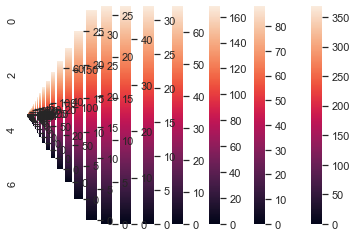

In [15]:
import os
files = os.listdir('weightedGraphs/csv/')
for f in files:
    if f.endswith('A.csv'):
        print()
        print()
        print("HANDLING ",f)
        AFile = 'weightedGraphs/csv/'+f
        BFile = 'weightedGraphs/csv/'+f.replace('A.csv','B.csv')
        %time computeMetrics_handleJVM(AFile,BFile,1.0,printModel,printPartitions,False)
#computeMetrics_handleJVM('weightedGraphs/csv/moviegalaxies_814A.csv','weightedGraphs/csv/moviegalaxies_814B.csv',1.0)

## Trash

In [16]:
py_metrics

NameError: name 'py_metrics' is not defined

In [ ]:
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
ax = sns.heatmap(py_metrics,annot=True,linewidths=.5)
plt.savefig('save_as_a_pdf.pdf')

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(py_metrics, cmap='hot', interpolation='nearest')
# plt.show()

In [ ]:
#%pip install seaborn